In [22]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from copy import deepcopy

In [3]:
# -----------------------------
# Data loading
# -----------------------------
df = pd.read_csv('Data/project_adult.csv', encoding='utf-8')

In [4]:
# process and standardize data
# This is not an all inclusive function....you should improve!
def preprocess_data(df):

    df = df.dropna()

    # Drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # split off target early (if present)
    y = None
    if 'income' in df.columns:
        y = df['income']
        df = df.drop(columns=['income'])
    
    if y is not None:
        le = LabelEncoder()
        y = le.fit_transform(y).astype(int)  # encode target as int

    # detect numeric vs categorical by attempted coercion
    numeric_cols, categorical_cols = [], []
    for col in df.columns:
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().all():
            df[col] = coerced.astype(float)   # numeric as float
            numeric_cols.append(col)
        else:
            df[col] = df[col].astype(str)     # categorical as string
            categorical_cols.append(col)
    
    # label-encode categoricals only
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype(int)  # encoded as int
        label_encoders[col] = le

    # standardize numeric columns only
    scaler = StandardScaler()
    if numeric_cols:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols].astype(float)).astype(float)

    # Encode categorical features
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le


    # Make X and y arrays
    X = df.values.astype(float)
    if y is not None:
        y = y.astype(int)

    return X, y

In [5]:
import numpy as np

# --- activations and derivatives ---

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def dsigmoid(a):
    # derivative in terms of activation output a = sigmoid(z)
    return a * (1. - a)

def tanh(z):
    return np.tanh(z)

def dtanh(a):
    # derivative in terms of activation output a = tanh(z)
    return 1. - a**2

def relu(z):
    return np.maximum(0.0, z)

def drelu(z):
    # derivative needs pre-activation z for ReLU
    out = np.zeros_like(z)
    out[z > 0] = 1.0
    return out

def softmax(z):
    # numerically stable softmax along last axis
    z_shift = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shift)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

# --- utils ---

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

# --- model ---

class NeuralNetMLP:
    """
    Two-layer MLP with pluggable hidden/output activations.
    Hidden activations supported: 'sigmoid', 'tanh', 'relu'
    Output activations supported: 'sigmoid', 'tanh', 'relu', 'softmax'
    Loss:
      - For output='softmax' uses multi-class cross-entropy by default
      - Otherwise uses mean squared error by default
    """

    def __init__(self, num_features, num_hidden, num_classes,
                 hidden_activation='sigmoid',
                 output_activation='sigmoid',
                 loss=None,
                 random_seed=123):
        super().__init__()

        self.num_classes = num_classes
        self.hidden_activation_name = hidden_activation.lower()
        self.output_activation_name = output_activation.lower()

        # choose loss if not provided
        if loss is None:
            self.loss_name = 'cross_entropy' if self.output_activation_name == 'softmax' else 'mse'
        else:
            self.loss_name = loss.lower()

        # init params
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    # --- activation dispatch ---

    def _act_hidden(self, z_h):
        if self.hidden_activation_name == 'sigmoid':
            a = sigmoid(z_h)
            cache = a  # derivative uses activation
            return a, cache
        elif self.hidden_activation_name == 'tanh':
            a = tanh(z_h)
            cache = a
            return a, cache
        elif self.hidden_activation_name == 'relu':
            a = relu(z_h)
            cache = z_h  # derivative uses pre-activation for ReLU
            return a, cache
        else:
            raise ValueError(f"Unsupported hidden activation: {self.hidden_activation_name}")

    def _dact_hidden(self, cache):
        if self.hidden_activation_name == 'sigmoid':
            return dsigmoid(cache)
        elif self.hidden_activation_name == 'tanh':
            return dtanh(cache)
        elif self.hidden_activation_name == 'relu':
            return drelu(cache)
        else:
            raise ValueError(f"Unsupported hidden activation: {self.hidden_activation_name}")

    def _act_out(self, z_out):
        if self.output_activation_name == 'sigmoid':
            a = sigmoid(z_out)
            cache = a
            return a, cache
        elif self.output_activation_name == 'tanh':
            a = tanh(z_out)
            cache = a
            return a, cache
        elif self.output_activation_name == 'relu':
            a = relu(z_out)
            cache = z_out
            return a, cache
        elif self.output_activation_name == 'softmax':
            a = softmax(z_out)
            cache = a  # for softmax+CE, derivative uses a directly
            return a, cache
        else:
            raise ValueError(f"Unsupported output activation: {self.output_activation_name}")

    def _dact_out(self, cache):
        if self.output_activation_name == 'sigmoid':
            return dsigmoid(cache)
        elif self.output_activation_name == 'tanh':
            return dtanh(cache)
        elif self.output_activation_name == 'relu':
            return drelu(cache)
        elif self.output_activation_name == 'softmax':
            # with cross-entropy, softmax derivative handled directly in backward
            # this function won't be used in that case
            raise RuntimeError("Do not call _dact_out for softmax; handled directly with cross-entropy.")
        else:
            raise ValueError(f"Unsupported output activation: {self.output_activation_name}")

    # --- forward/backward ---

    def forward(self, x):
        # hidden layer: z_h -> a_h
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h, hidden_cache = self._act_hidden(z_h)

        # output layer: z_out -> a_out
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out, out_cache = self._act_out(z_out)

        cache = {
            'x': x,
            'z_h': z_h,
            'a_h': a_h,
            'hidden_cache': hidden_cache,
            'z_out': z_out,
            'a_out': a_out,
            'out_cache': out_cache
        }
        return a_h, a_out, cache

    def backward(self, y, cache):
        """
        Computes gradients for weights and biases using the chosen activations and loss.
        y is class indices of shape [n_examples].
        """
        x = cache['x']
        a_h = cache['a_h']
        a_out = cache['a_out']

        y_onehot = int_to_onehot(y, self.num_classes)
        N = y.shape[0]

        # delta_out based on loss and output activation
        if self.loss_name == 'cross_entropy' and self.output_activation_name == 'softmax':
            # gradient wrt logits for softmax+CE
            delta_out = (a_out - y_onehot) / N
        elif self.loss_name == 'mse':
            # MSE: dL/da = 2*(a - y)/N; then multiply by activation derivative wrt logits
            d_loss__d_a_out = 2.0 * (a_out - y_onehot) / N
            if self.output_activation_name == 'softmax':
                # not typical, but provide a safe fallback via full Jacobian-vector product
                # J_softmax = diag(a) - a a^T ; compute row-wise
                delta_out = np.empty_like(a_out)
                for i in range(N):
                    a = a_out[i:i+1]          # shape (1, C)
                    v = d_loss__d_a_out[i:i+1]  # shape (1, C)
                    jac = np.diagflat(a) - a.T @ a  # (C, C)
                    delta_out[i] = (v @ jac).ravel()
            else:
                d_a_out__d_z_out = self._dact_out(cache['out_cache'])
                delta_out = d_loss__d_a_out * d_a_out__d_z_out
        else:
            raise ValueError(f"Unsupported loss/activation combo: loss={self.loss_name}, out_act={self.output_activation_name}")

        # gradients for output layer
        d_loss__dw_out = np.dot(delta_out.T, a_h)           # (num_classes, num_hidden)
        d_loss__db_out = np.sum(delta_out, axis=0)          # (num_classes,)

        # backprop to hidden activations
        d_loss__a_h = np.dot(delta_out, self.weight_out)    # (N, num_hidden)

        # hidden activation derivative
        d_a_h__d_z_h = self._dact_hidden(cache['hidden_cache'])

        # gradients for hidden layer
        delta_h = d_loss__a_h * d_a_h__d_z_h                 # (N, num_hidden)
        d_loss__d_w_h = np.dot(delta_h.T, x)                 # (num_hidden, num_features)
        d_loss__d_b_h = np.sum(delta_h, axis=0)              # (num_hidden,)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)

    # optional helper: compute loss for monitoring
    def loss(self, y, a_out):
        y_onehot = int_to_onehot(y, self.num_classes)
        if self.loss_name == 'cross_entropy' and self.output_activation_name == 'softmax':
            # small epsilon for stability
            eps = 1e-12
            probs = np.clip(a_out, eps, 1.0 - eps)
            # mean negative log likelihood
            return -np.mean(np.sum(y_onehot * np.log(probs), axis=1))
        elif self.loss_name == 'mse':
            return np.mean((a_out - y_onehot) ** 2)
        else:
            raise ValueError(f"Unsupported loss: {self.loss_name}")

In [6]:
def plot_confusion_matrix(cm, y_true):
    # Heatmap with consistent label order [-1, +1]
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ticks = [-1, 1]
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=ticks, yticklabels=ticks,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2. if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [7]:
X_all, y_all = preprocess_data(df)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

In [18]:
# infer dimensions from the test split
num_features = X_test.shape[1]
num_classes = 2 # assumes labels are 0..C-1

# instantiate model with the new pluggable-activation API
model = NeuralNetMLP(
    num_features=num_features,
    num_hidden=50,
    num_classes=num_classes,
    hidden_activation='relu',      # reasonable default for hidden
    output_activation='softmax'    # proper multi-class output
)

# forward pass on the test set
_, probas, _ = model.forward(X_test)

# for softmax outputs, the built-in loss() uses cross-entropy
test_loss = model.loss(y_test, probas)

# basic accuracy
predicted_labels = np.argmax(probas, axis=1)
test_acc = np.mean(predicted_labels == y_test)

# quick sanity check: rows should sum to ~1 with softmax
row_sum_check = np.mean(np.abs(np.sum(probas, axis=1) - 1.0))

print(f"Initial test cross-entropy: {test_loss:.4f}")
print(f"Initial test accuracy: {test_acc*100:.2f}%")
print(f"Mean |sum(probas)-1| across rows: {row_sum_check:.2e}")

# optional: if switching to a non-softmax output with MSE, use this helper
def mse_loss(targets, probas, num_labels=num_classes):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas) ** 2)


Initial test cross-entropy: 1.2818
Initial test accuracy: 75.93%
Mean |sum(probas)-1| across rows: 3.94e-17


In [28]:
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

# --- sklearn-compatible wrapper ---

class MLPClassifierSk(BaseEstimator, ClassifierMixin):
    # keep only tunable hyperparameters as __init__ args
    def __init__(self,
                 num_hidden=64,
                 hidden_activation='relu',
                 output_activation='softmax',
                 epochs=20,
                 batch_size=64,
                 lr=0.1,
                 random_seed=123):
        # sklearn picks these up automatically for cloning/grid search
        self.num_hidden = num_hidden
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.random_seed = random_seed

        # non-hyperparams initialized later
        self.model_ = None
        self.num_classes_ = None
        self.num_features_ = None

    def _init_model(self, X, y):
        self.num_features_ = X.shape[1]
        self.num_classes_ = int(np.max(y)) + 1
        self.model_ = NeuralNetMLP(
            num_features=self.num_features_,
            num_hidden=self.num_hidden,
            num_classes=self.num_classes_,
            hidden_activation=self.hidden_activation,
            output_activation=self.output_activation,
            random_seed=self.random_seed
        )

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_seed)
        y = y.astype(int)
        self._init_model(X, y)

        for _ in range(self.epochs):
            idx = rng.permutation(len(X))
            X_shuf, y_shuf = X[idx], y[idx]

            for start in range(0, len(X_shuf), self.batch_size):
                end = start + self.batch_size
                xb = X_shuf[start:end]
                yb = y_shuf[start:end]

                _, a_out, cache = self.model_.forward(xb)
                dW_out, db_out, dW_h, db_h = self.model_.backward(yb, cache)

                # SGD step
                self.model_.weight_out -= self.lr * dW_out
                self.model_.bias_out   -= self.lr * db_out
                self.model_.weight_h   -= self.lr * dW_h
                self.model_.bias_h     -= self.lr * db_h
        return self

    def predict_proba(self, X):
        _, scores, _ = self.model_.forward(X)
        # enforce probabilities for any output activation
        return softmax(scores)

    def predict(self, X):
        probas = self.predict_proba(X)
        return np.argmax(probas, axis=1)

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

In [34]:
# --- grid search using only X_train/y_train with internal CV, then evaluate on X_test/y_test ---

# ensure labels are ints and 0..C-1
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [35]:
param_grid = {
    'hidden_activation': ['relu', 'tanh', 'sigmoid'],
    'output_activation': ['softmax'],       # keep softmax for multi-class (and binary with 2 logits)
    'num_hidden': [32, 64, 128],
    'epochs': [20, 40, 80],
    'batch_size': [32, 64, 128],
    'lr': [0.01, 0.05, 0.1]
}

gs = GridSearchCV(
    estimator=MLPClassifierSk(random_seed=123),
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=1,
    refit=True,
    verbose=1
)

gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
print("Best CV accuracy: {:.4f}".format(gs.best_score_))

best_clf = gs.best_estimator_
test_acc = best_clf.score(X_test, y_test)
probas_test = best_clf.predict_proba(X_test)
row_sum_err = np.mean(np.abs(np.sum(probas_test, axis=1) - 1.0))

print("Test accuracy: {:.4f}".format(test_acc))
print("Mean |sum(probas)-1| on test: {:.2e}".format(row_sum_err))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'batch_size': 32, 'epochs': 80, 'hidden_activation': 'sigmoid', 'lr': 0.05, 'num_hidden': 128, 'output_activation': 'softmax'}
Best CV accuracy: 0.8431
Test accuracy: 0.8401
Mean |sum(probas)-1| on test: 9.40e-18



--- Confusion Matrix ---
[[3686  270]
 [ 563  691]]

--- Classification Report ---
              precision    recall  f1-score   support

  <=50K (-1)       0.87      0.93      0.90      3956
   >50K (+1)       0.72      0.55      0.62      1254

    accuracy                           0.84      5210
   macro avg       0.79      0.74      0.76      5210
weighted avg       0.83      0.84      0.83      5210



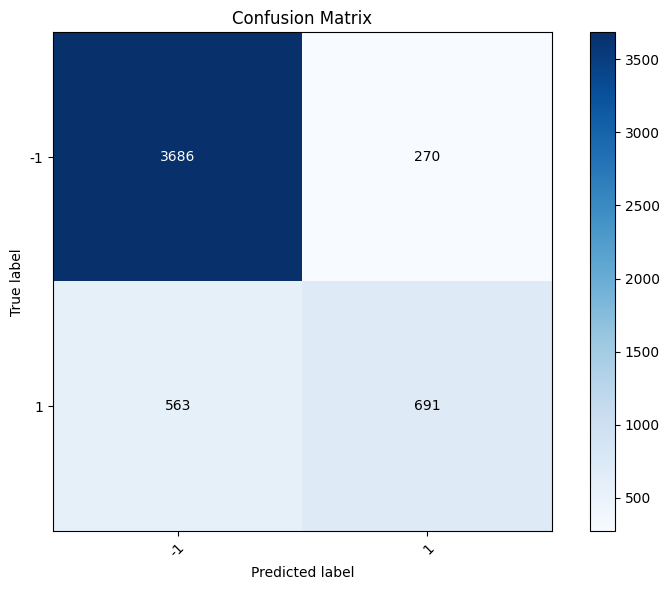

In [38]:
# predict on the test set using the best estimator
best_model = gs.best_estimator_
y_pred = best_model.predict(X_test)

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(cm)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['<=50K (-1)', '>50K (+1)']))

plot_confusion_matrix(cm, y_test)

In [39]:
# Validation set using the SAME preprocessing state
df_valid = pd.read_csv('Data/project_validation_inputs.csv', encoding='utf-8')
X_valid, y_valid = preprocess_data(df_valid)

print("Predictions for the validation inputs:")
y_pred_valid = best_model.predict(X_valid)

# Convert predictions: 0 -> -1, 1 -> 1
y_pred_valid = np.where(y_pred_valid == 0, -1, 1)

print(y_pred_valid)

# save results with predictions
validation_results_df = pd.DataFrame(X_valid)
validation_results_df['predicted_income_pm1'] = y_pred_valid
validation_results_df.to_csv('validation_predictions.csv', index=False)

print("Validation inputs and predictions saved to 'validation_predictions.csv'")

Predictions for the validation inputs:
[-1 -1  1 ...  1 -1 -1]
Validation inputs and predictions saved to 'validation_predictions.csv'
